# Distance Analysis with abagpdb

This notebook demonstrates how to **calculate and analyze pairwise distances** between atoms and residues using the `abagpdb` package.

## Overview

Distance calculations enable you to:
- **Atom-level distances**: Compute pairwise distances between all atoms
- **Residue-level distances**: Calculate distances between residues (CA-CA or minimum)
- **Contact identification**: Find close contacts and interfaces
- **Distance matrices**: Generate distance maps for visualization
- **Selection-based analysis**: Compare specific regions (e.g., antibody vs antigen)

## Distance Calculation Modes

| Mode | Level | Description | Use Case |
|------|-------|-------------|----------|
| **Atom-wise** | Atom | Distance between individual atoms | Detailed contact analysis |
| **CA-CA** | Residue | Distance between alpha carbons | Quick structural comparison |
| **Min** | Residue | Minimum atom-atom distance | Interface detection |
| **All-vs-all** | Complex | Full distance matrix | Global distance mapping |

---

## Example System: Antibody-Antigen Complex (PDB: 5GGS)

## 1. Setup and Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PyPDBcomplex.pdbparser import parse_pdb
from PyPDBcomplex.distances import (
    pairwise_min_distance,
    atom_distance_matrix,
    residue_distance_matrix,
    all_distance_matrix,
    selection_distance_matrix
)

## 2. Load PDB Structure

In [2]:
# Parse the PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("✓ Structure loaded successfully!")
print(f"  File: {cx.source_path}")
print(f"  Chains: {', '.join(cx.chains.keys())}")

# Count atoms and residues per chain
for chain_id, chain in cx.chains.items():
    n_residues = len(chain.residues)
    n_atoms = sum(len(r.atoms) for r in chain.residues.values())
    print(f"  Chain {chain_id}: {n_residues} residues, {n_atoms} atoms")

✓ Structure loaded successfully!
  File: 5GGS_wt.pdb
  Chains: A, H, L
  Chain A: 113 residues, 890 atoms
  Chain H: 219 residues, 1660 atoms
  Chain L: 217 residues, 1666 atoms


## 3. Atom-Level Distance Matrix

Calculate pairwise distances between all atoms in selected regions.

In [4]:
# Compute atom-wise distance matrix between antibody (H,L) and antigen (A)
D_atom, ab_atoms, ag_atoms = atom_distance_matrix(
    cx, 
    selA=["H","L"],  # Antibody heavy and light chains
    selB="A",     # Antigen chain
    ignore_h=True # Ignore hydrogen atoms
)

print("="* 80)
print("ATOM-WISE DISTANCE MATRIX COMPUTED".center(80))
print("=" * 80)
print(f"Matrix shape: {D_atom.shape if hasattr(D_atom, 'shape') else (len(D_atom), len(D_atom[0]))}")
print(f"Antibody atoms: {len(ab_atoms)}")
print(f"Antigen atoms:  {len(ag_atoms)}")
print(f"\nDistance statistics (Å):")

# Convert to numpy array if needed
if not hasattr(D_atom, 'min'):
    D_flat = [d for row in D_atom for d in row]
    print(f"  Minimum:  {min(D_flat):.2f}")
    print(f"  Maximum:  {max(D_flat):.2f}")
    print(f"  Mean:     {np.mean(D_flat):.2f}")
else:
    print(f"  Minimum:  {D_atom.min():.2f}")
    print(f"  Maximum:  {D_atom.max():.2f}")
    print(f"  Mean:     {D_atom.mean():.2f}")

print("=" * 80)

                       ATOM-WISE DISTANCE MATRIX COMPUTED                       
Matrix shape: (3326, 890)
Antibody atoms: 3326
Antigen atoms:  890

Distance statistics (Å):
  Minimum:  2.40
  Maximum:  100.33
  Mean:     49.09


### Visualize Atom Distance Matrix

Create a heatmap showing atom-atom distances.

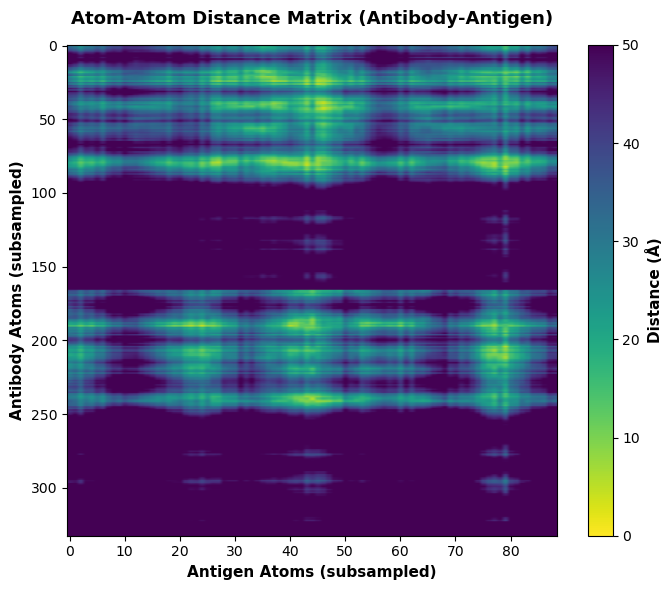

Heatmap shows every 10th atom for visualization


In [36]:
# Plot distance matrix heatmap (subsample for visibility)
fig, ax = plt.subplots(figsize=(7, 6))

# Subsample every 10th atom for visualization
step = 10
if hasattr(D_atom, 'shape'):
    D_sub = D_atom[::step, ::step]
else:
    D_sub = [row[::step] for row in D_atom[::step]]

im = ax.imshow(D_sub, cmap='viridis_r', aspect='auto', vmin=0, vmax=50)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Distance (Å)', fontweight='bold', fontsize=11)

ax.set_xlabel('Antigen Atoms (subsampled)', fontweight='bold', fontsize=11)
ax.set_ylabel('Antibody Atoms (subsampled)', fontweight='bold', fontsize=11)
ax.set_title('Atom-Atom Distance Matrix (Antibody-Antigen)', 
             fontweight='bold', fontsize=13, pad=15)

plt.tight_layout()
plt.show()

print(f"Heatmap shows every {step}th atom for visualization")

### Find Closest Atom-Atom Contacts

In [10]:
# Find the 10 closest atom-atom contacts
print("="* 80)
print("TOP 10 CLOSEST ATOM-ATOM CONTACTS".center(80))
print("=" * 80)

# Convert to list of (distance, ab_idx, ag_idx) tuples
contacts = []
if hasattr(D_atom, 'shape'):
    for i in range(D_atom.shape[0]):
        for j in range(D_atom.shape[1]):
            contacts.append((D_atom[i, j], i, j))
else:
    for i, row in enumerate(D_atom):
        for j, d in enumerate(row):
            contacts.append((d, i, j))

# Sort by distance
contacts.sort(key=lambda x: x[0])

print(f"{'Rank':<6}{'Antibody Atom':<30}{'Antigen Atom':<30}{'Distance (Å)':<15}")
print("-" * 80)

for rank, (dist, ab_idx, ag_idx) in enumerate(contacts[:10], 1):
    print(f"{rank:<6}{ab_atoms[ab_idx]:<30}{ag_atoms[ag_idx]:<30}{dist:<15.2f}")

print("=" * 80)

                       TOP 10 CLOSEST ATOM-ATOM CONTACTS                        
Rank  Antibody Atom                 Antigen Atom                  Distance (Å)   
--------------------------------------------------------------------------------
1     L:34.OH                       A:33.O                        2.40           
2     L:53.OH                       A:98.O                        2.42           
3     H:101.NH1                     A:102.O                       2.62           
4     H:34.OH                       A:57.O                        2.71           
5     H:98.NH1                      A:57.OG                       2.78           
6     H:98.NH2                      A:55.OD2                      2.80           
7     H:100.O                       A:48.NZ                       2.81           
8     H:98.NH1                      A:55.OD1                      2.86           
9     H:100.OH                      A:46.OG1                      2.89           
10    L:59.OE1    

## 4. Residue-Level Distance Matrix (Minimum Mode)

Calculate minimum atom-atom distance between residues.

In [11]:
# Compute residue-wise minimum distance matrix
D_min, ab_residues, ag_residues = residue_distance_matrix(
    cx,
    selA="H,L",
    selB="A",
    mode="min",
    ignore_h=True
)

print("=" * 80)
print("RESIDUE-WISE MINIMUM DISTANCE MATRIX COMPUTED".center(80))
print("=" * 80)
print(f"Matrix shape: {D_min.shape if hasattr(D_min, 'shape') else (len(D_min), len(D_min[0]))}")
print(f"Antibody residues: {len(ab_residues)}")
print(f"Antigen residues:  {len(ag_residues)}")
print(f"\nDistance statistics (Å):")

if not hasattr(D_min, 'min'):
    D_flat = [d for row in D_min for d in row]
    print(f"  Minimum:  {min(D_flat):.2f}")
    print(f"  Maximum:  {max(D_flat):.2f}")
    print(f"  Mean:     {np.mean(D_flat):.2f}")
else:
    print(f"  Minimum:  {D_min.min():.2f}")
    print(f"  Maximum:  {D_min.max():.2f}")
    print(f"  Mean:     {D_min.mean():.2f}")

print("=" * 80)

                 RESIDUE-WISE MINIMUM DISTANCE MATRIX COMPUTED                  
Matrix shape: (436, 113)
Antibody residues: 436
Antigen residues:  113

Distance statistics (Å):
  Minimum:  2.40
  Maximum:  93.59
  Mean:     46.46


### Visualize Residue Distance Matrix (Min Mode)

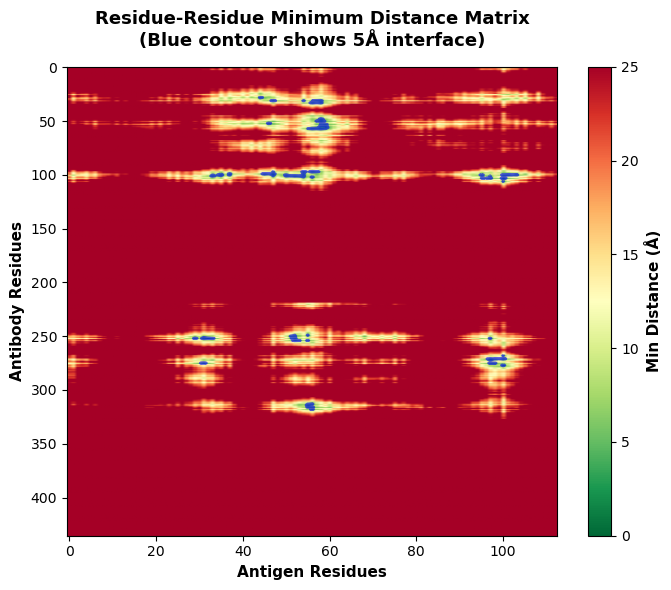

In [35]:
# Plot residue distance heatmap
fig, ax = plt.subplots(figsize=(7, 6))

# Convert to numpy if needed
if not hasattr(D_min, 'shape'):
    D_min_np = np.array(D_min)
else:
    D_min_np = D_min

im = ax.imshow(D_min_np, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=25)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Min Distance (Å)', fontweight='bold', fontsize=11)

# Add contour for interface (< 5 Å)
contour = ax.contour(D_min_np, levels=[5.0], colors='blue', linewidths=2, alpha=0.6)
ax.clabel(contour, inline=True, fontsize=10, fmt='5Å interface')

ax.set_xlabel('Antigen Residues', fontweight='bold', fontsize=11)
ax.set_ylabel('Antibody Residues', fontweight='bold', fontsize=11)
ax.set_title('Residue-Residue Minimum Distance Matrix\n(Blue contour shows 5Å interface)', 
             fontweight='bold', fontsize=13, pad=15)

plt.tight_layout()
plt.show()

### Find Interface Residues (< 5 Å)

In [15]:
# Identify interface residues (minimum distance < 5 Å)
cutoff = 5.0

interface_pairs = []
if hasattr(D_min, 'shape'):
    for i in range(D_min.shape[0]):
        for j in range(D_min.shape[1]):
            if D_min[i, j] <= cutoff:
                interface_pairs.append((ab_residues[i], ag_residues[j], D_min[i, j]))
else:
    for i, row in enumerate(D_min):
        for j, d in enumerate(row):
            if d <= cutoff:
                interface_pairs.append((ab_residues[i], ag_residues[j], d))

# Get unique interface residues
ab_interface = set(pair[0] for pair in interface_pairs)
ag_interface = set(pair[1] for pair in interface_pairs)

print("=" * 80)
print(f"INTERFACE RESIDUES (< {cutoff} Å)".center(80))
print("=" * 80)
print(f"Total residue-residue contacts: {len(interface_pairs)}")
print(f"Antibody interface residues:    {len(ab_interface)}")
print(f"Antigen interface residues:     {len(ag_interface)}")

print(f"\nAntibody interface residues:")
ab_sorted = sorted(ab_interface, key=lambda x: (x.split(':')[0], int(''.join(filter(str.isdigit, x.split(':')[1])))))
for i in range(0, len(ab_sorted), 10):
    print("  " + ", ".join(ab_sorted[i:i+10]))

print(f"\nAntigen interface residues:")
ag_sorted = sorted(ag_interface, key=lambda x: (x.split(':')[0], int(''.join(filter(str.isdigit, x.split(':')[1])))))
for i in range(0, len(ag_sorted), 10):
    print("  " + ", ".join(ag_sorted[i:i+10]))

print("=" * 80)

                          INTERFACE RESIDUES (< 5.0 Å)                          
Total residue-residue contacts: 88
Antibody interface residues:    32
Antigen interface residues:     27

Antibody interface residues:
  ARG H:98, ARG H:101, ARG L:96, ASN H:51, ASN H:54, ASN H:58, ASP H:103, ASP H:107, ASP L:97, GLU L:59
  GLY H:49, GLY H:56, ILE H:50, LEU L:50, LEU L:54, LEU L:98, LEU L:100, MET H:104, PHE H:102, SER H:53
  SER L:32, SER L:95, THR H:29, THR H:57, THR L:31, TYR H:32, TYR H:34, TYR H:100, TYR L:34, TYR L:36
  TYR L:53, TYR L:57

Antigen interface residues:
  ALA A:51, ALA A:99, ALA A:102, ARG A:56, ASN A:36, ASP A:47, ASP A:55, GLN A:45, GLN A:58, GLN A:103
  GLU A:54, GLY A:60, ILE A:96, ILE A:104, LEU A:98, LYS A:48, LYS A:101, PHE A:33, PHE A:52, PRO A:53
  PRO A:59, SER A:30, SER A:32, SER A:57, THR A:46, TYR A:38, VAL A:34


## 5. Residue-Level Distance Matrix (CA Mode)

Calculate CA-CA distances between residues.

In [16]:
# Compute residue-wise CA-CA distance matrix
D_ca, ab_residues_ca, ag_residues_ca = residue_distance_matrix(
    cx,
    selA="H,L",
    selB="A",
    mode="CA",
    ignore_h=True
)

print("=" * 80)
print("RESIDUE-WISE CA-CA DISTANCE MATRIX COMPUTED".center(80))
print("=" * 80)
print(f"Matrix shape: {D_ca.shape if hasattr(D_ca, 'shape') else (len(D_ca), len(D_ca[0]))}")
print(f"\nCA-CA distance statistics (Å):")

# Handle NaN values in CA mode
if hasattr(D_ca, 'shape'):
    valid_distances = D_ca[~np.isnan(D_ca)]
    print(f"  Valid distances:  {len(valid_distances)}")
    print(f"  Minimum:  {valid_distances.min():.2f}")
    print(f"  Maximum:  {valid_distances.max():.2f}")
    print(f"  Mean:     {valid_distances.mean():.2f}")
else:
    valid_distances = [d for row in D_ca for d in row if not np.isnan(d)]
    print(f"  Valid distances:  {len(valid_distances)}")
    print(f"  Minimum:  {min(valid_distances):.2f}")
    print(f"  Maximum:  {max(valid_distances):.2f}")
    print(f"  Mean:     {np.mean(valid_distances):.2f}")

print("=" * 80)

                  RESIDUE-WISE CA-CA DISTANCE MATRIX COMPUTED                   
Matrix shape: (436, 113)

CA-CA distance statistics (Å):
  Valid distances:  49268
  Minimum:  3.61
  Maximum:  95.74
  Mean:     49.51


### Compare Min vs CA Distance Modes

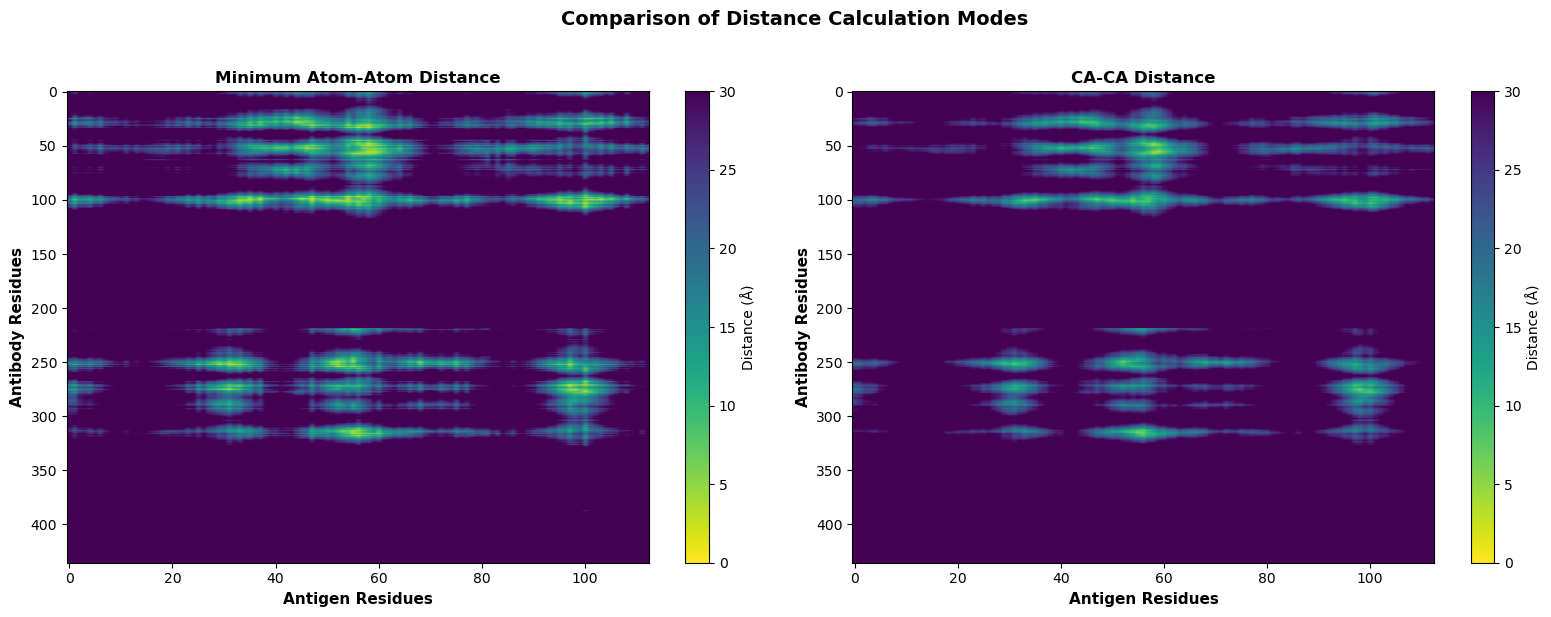


Observation: Min mode shows closer contacts (sidechain interactions),
while CA mode provides a backbone-based distance estimate.


In [17]:
# Compare the two distance calculation modes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Convert to numpy if needed
if not hasattr(D_min, 'shape'):
    D_min_np = np.array(D_min)
    D_ca_np = np.array(D_ca)
else:
    D_min_np = D_min
    D_ca_np = D_ca

# Plot 1: Min distance mode
im1 = axes[0].imshow(D_min_np, cmap='viridis_r', aspect='auto', vmin=0, vmax=30)
axes[0].set_xlabel('Antigen Residues', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Antibody Residues', fontweight='bold', fontsize=11)
axes[0].set_title('Minimum Atom-Atom Distance', fontweight='bold', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Distance (Å)')

# Plot 2: CA-CA distance mode
im2 = axes[1].imshow(D_ca_np, cmap='viridis_r', aspect='auto', vmin=0, vmax=30)
axes[1].set_xlabel('Antigen Residues', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Antibody Residues', fontweight='bold', fontsize=11)
axes[1].set_title('CA-CA Distance', fontweight='bold', fontsize=12)
plt.colorbar(im2, ax=axes[1], label='Distance (Å)')

plt.suptitle('Comparison of Distance Calculation Modes', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservation: Min mode shows closer contacts (sidechain interactions),")
print("while CA mode provides a backbone-based distance estimate.")

## 6. Distance Distribution Analysis

Analyze the distribution of distances to understand structural features.

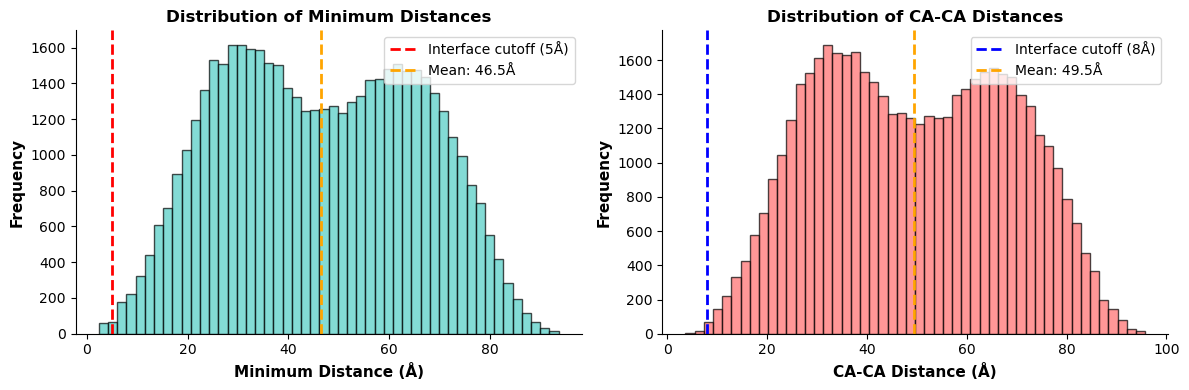


Distance Distribution Statistics:

Minimum Distance Mode:
  Contacts < 5Å:  88
  Contacts < 8Å:  319
  Contacts < 10Å: 571

CA-CA Distance Mode:
  Contacts < 8Å:  46
  Contacts < 12Å: 340
  Contacts < 15Å: 848


In [20]:
# Plot distance distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of minimum distances
if hasattr(D_min, 'shape'):
    min_distances = D_min.flatten()
else:
    min_distances = [d for row in D_min for d in row]

axes[0].hist(min_distances, bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[0].axvline(5.0, color='red', linestyle='--', linewidth=2, 
                label='Interface cutoff (5Å)')
axes[0].axvline(np.mean(min_distances), color='orange', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(min_distances):.1f}Å')
axes[0].set_xlabel('Minimum Distance (Å)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0].set_title('Distribution of Minimum Distances', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Histogram of CA-CA distances (excluding NaN)
if hasattr(D_ca, 'shape'):
    ca_distances = D_ca[~np.isnan(D_ca)]
else:
    ca_distances = [d for row in D_ca for d in row if not np.isnan(d)]

axes[1].hist(ca_distances, bins=50, color='#FF6B6B', edgecolor='black', alpha=0.7)
axes[1].axvline(8.0, color='blue', linestyle='--', linewidth=2,
                label='Interface cutoff (8Å)')
axes[1].axvline(np.mean(ca_distances), color='orange', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(ca_distances):.1f}Å')
axes[1].set_xlabel('CA-CA Distance (Å)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[1].set_title('Distribution of CA-CA Distances', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Statistics
print("\nDistance Distribution Statistics:")
print(f"\nMinimum Distance Mode:")
print(f"  Contacts < 5Å:  {sum(1 for d in min_distances if d <= 5.0)}")
print(f"  Contacts < 8Å:  {sum(1 for d in min_distances if d <= 8.0)}")
print(f"  Contacts < 10Å: {sum(1 for d in min_distances if d <= 10.0)}")

print(f"\nCA-CA Distance Mode:")
print(f"  Contacts < 8Å:  {sum(1 for d in ca_distances if d <= 8.0)}")
print(f"  Contacts < 12Å: {sum(1 for d in ca_distances if d <= 12.0)}")
print(f"  Contacts < 15Å: {sum(1 for d in ca_distances if d <= 15.0)}")

## 7. All-vs-All Distance Matrix

Calculate distance matrix for the entire complex.

In [21]:
# Compute all-vs-all residue distance matrix (CA mode for speed)
D_all, all_labels = all_distance_matrix(
    cx,
    level="residue",
    residue_mode="CA",
    ignore_h=True
)

print("=" * 80)
print("ALL-VS-ALL DISTANCE MATRIX COMPUTED".center(80))
print("=" * 80)
print(f"Matrix shape: {D_all.shape if hasattr(D_all, 'shape') else (len(D_all), len(D_all[0]))}")
print(f"Total residues: {len(all_labels)}")
print(f"\nChain breakdown:")

# Count residues per chain
chain_counts = {}
for label in all_labels:
    chain = label.split(':')[0].split()[-1]  # Extract chain ID
    chain_counts[chain] = chain_counts.get(chain, 0) + 1

for chain, count in sorted(chain_counts.items()):
    print(f"  Chain {chain}: {count} residues")

print("=" * 80)

                      ALL-VS-ALL DISTANCE MATRIX COMPUTED                       
Matrix shape: (549, 549)
Total residues: 549

Chain breakdown:
  Chain A: 113 residues
  Chain H: 219 residues
  Chain L: 217 residues


### Visualize All-vs-All Distance Matrix

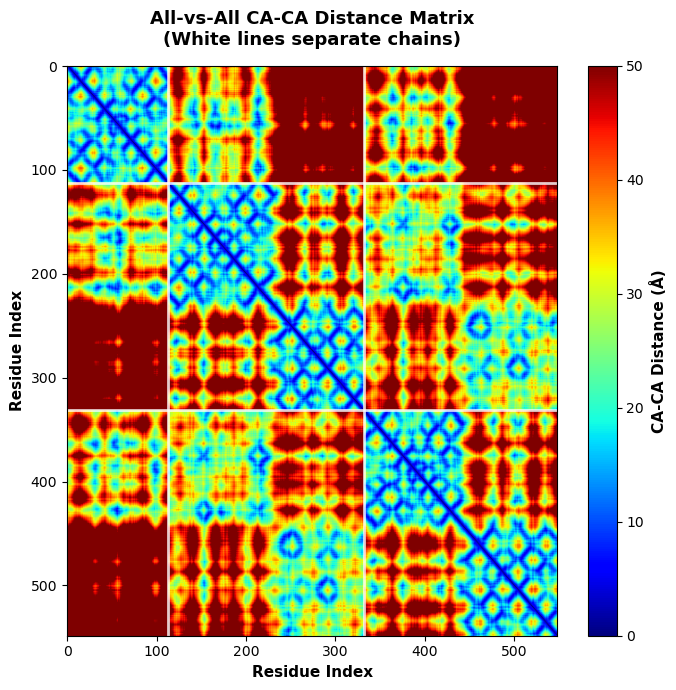

Note: Dark blue regions indicate close contacts (intra-chain or inter-chain).
      Yellow/red regions indicate distant residues.


In [22]:
# Plot full distance matrix
fig, ax = plt.subplots(figsize=(7, 7))

# Convert to numpy if needed
if not hasattr(D_all, 'shape'):
    D_all_np = np.array(D_all)
else:
    D_all_np = D_all

# Mask NaN values
D_all_masked = np.ma.masked_invalid(D_all_np)

im = ax.imshow(D_all_masked, cmap='jet', aspect='auto', vmin=0, vmax=50)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('CA-CA Distance (Å)', fontweight='bold', fontsize=11)

# Add chain boundaries
cumsum = 0
for chain, count in sorted(chain_counts.items()):
    cumsum += count
    if cumsum < len(all_labels):
        ax.axhline(cumsum - 0.5, color='white', linewidth=2, alpha=0.8)
        ax.axvline(cumsum - 0.5, color='white', linewidth=2, alpha=0.8)

ax.set_xlabel('Residue Index', fontweight='bold', fontsize=11)
ax.set_ylabel('Residue Index', fontweight='bold', fontsize=11)
ax.set_title('All-vs-All CA-CA Distance Matrix\n(White lines separate chains)', 
             fontweight='bold', fontsize=13, pad=15)

plt.tight_layout()
plt.show()

print("Note: Dark blue regions indicate close contacts (intra-chain or inter-chain).")
print("      Yellow/red regions indicate distant residues.")

## 8. Export to DataFrame

Convert distance matrices to pandas DataFrames for further analysis.

In [23]:
# Create DataFrame for interface contacts (min distance < 5Å)
interface_data = []

cutoff = 5.0
if hasattr(D_min, 'shape'):
    for i in range(D_min.shape[0]):
        for j in range(D_min.shape[1]):
            if D_min[i, j] <= cutoff:
                interface_data.append({
                    'antibody_residue': ab_residues[i],
                    'antigen_residue': ag_residues[j],
                    'min_distance': D_min[i, j],
                    'ca_distance': D_ca[i, j] if not np.isnan(D_ca[i, j]) else None
                })
else:
    for i, row in enumerate(D_min):
        for j, d in enumerate(row):
            if d <= cutoff:
                ca_dist = D_ca[i][j] if not np.isnan(D_ca[i][j]) else None
                interface_data.append({
                    'antibody_residue': ab_residues[i],
                    'antigen_residue': ag_residues[j],
                    'min_distance': d,
                    'ca_distance': ca_dist
                })

df_interface = pd.DataFrame(interface_data)

print("DataFrame created successfully!")
print(f"\nInterface contacts DataFrame: {df_interface.shape[0]} rows × {df_interface.shape[1]} columns")
print(f"Columns: {list(df_interface.columns)}")

print(f"\nFirst 15 interface contacts (sorted by distance):")
df_interface.sort_values('min_distance').head(15)

DataFrame created successfully!

Interface contacts DataFrame: 88 rows × 4 columns
Columns: ['antibody_residue', 'antigen_residue', 'min_distance', 'ca_distance']

First 15 interface contacts (sorted by distance):


,antibody_residue,antigen_residue,min_distance,ca_distance
65,TYR L:34,PHE A:33,2.395779,9.898024
73,TYR L:53,LEU A:98,2.419637,9.492754
42,ARG H:101,ALA A:102,2.622013,10.085320
5,TYR H:34,SER A:57,2.713097,10.080837
26,ARG H:98,SER A:57,2.777207,9.873421
25,ARG H:98,ASP A:55,2.804464,11.771849
32,TYR H:100,LYS A:48,2.805913,7.513107
30,TYR H:100,THR A:46,2.889932,10.520022
80,GLU L:59,LYS A:101,2.890270,8.383452
57,MET H:104,LYS A:101,2.977852,7.989704


### Summary Statistics by Residue

In [24]:
# Count contacts per antibody residue
ab_contact_counts = df_interface.groupby('antibody_residue').size().sort_values(ascending=False)

print("="* 80)
print("TOP 15 ANTIBODY RESIDUES BY NUMBER OF CONTACTS".center(80))
print("=" * 80)
print(f"{'Rank':<6}{'Residue':<25}{'Contact Count':<15}{'Avg Min Dist (Å)':<20}")
print("-" * 80)

for rank, (residue, count) in enumerate(ab_contact_counts.head(15).items(), 1):
    avg_dist = df_interface[df_interface['antibody_residue'] == residue]['min_distance'].mean()
    print(f"{rank:<6}{residue:<25}{count:<15}{avg_dist:<20.2f}")

print("=" * 80)

# Count contacts per antigen residue
ag_contact_counts = df_interface.groupby('antigen_residue').size().sort_values(ascending=False)

print("\n" + "=" * 80)
print("TOP 15 ANTIGEN RESIDUES BY NUMBER OF CONTACTS".center(80))
print("=" * 80)
print(f"{'Rank':<6}{'Residue':<25}{'Contact Count':<15}{'Avg Min Dist (Å)':<20}")
print("-" * 80)

for rank, (residue, count) in enumerate(ag_contact_counts.head(15).items(), 1):
    avg_dist = df_interface[df_interface['antigen_residue'] == residue]['min_distance'].mean()
    print(f"{rank:<6}{residue:<25}{count:<15}{avg_dist:<20.2f}")

print("=" * 80)

                 TOP 15 ANTIBODY RESIDUES BY NUMBER OF CONTACTS                 
Rank  Residue                  Contact Count  Avg Min Dist (Å)    
--------------------------------------------------------------------------------
1     ARG H:101                11             3.81                
2     PHE H:102                8              4.30                
3     TYR L:34                 6              3.43                
4     TYR H:100                6              3.86                
5     ASN H:58                 5              3.99                
6     ARG H:98                 4              3.47                
7     TYR H:32                 4              3.51                
8     TYR L:53                 3              3.23                
9     TYR L:36                 3              4.00                
10    TYR H:34                 3              3.50                
11    MET H:104                3              3.92                
12    TYR L:57                 3  

## 9. Contact Map Visualization

Create a binary contact map showing which residues are in contact.

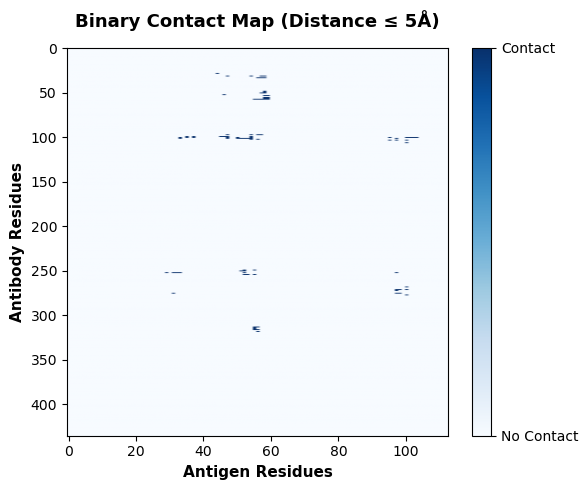


Total residue-residue contacts (≤ 5Å): 88
Percentage of possible contacts: 0.18%


In [29]:
# Create binary contact map (1 if contact, 0 otherwise)
if hasattr(D_min, 'shape'):
    contact_map = (D_min <= 5.0).astype(int)
else:
    contact_map = np.array([[1 if d <= 5.0 else 0 for d in row] for row in D_min])

# Plot contact map
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(contact_map, cmap='Blues', aspect='auto', vmin=0, vmax=1)
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['No Contact', 'Contact'])
cbar.ax.tick_params(labelsize=10)

ax.set_xlabel('Antigen Residues', fontweight='bold', fontsize=11)
ax.set_ylabel('Antibody Residues', fontweight='bold', fontsize=11)
ax.set_title('Binary Contact Map (Distance ≤ 5Å)', 
             fontweight='bold', fontsize=13, pad=15)

plt.tight_layout()
plt.show()

total_contacts = contact_map.sum()
print(f"\nTotal residue-residue contacts (≤ 5Å): {total_contacts}")
print(f"Percentage of possible contacts: {100 * total_contacts / contact_map.size:.2f}%")

## 10. Chain-Specific Distance Analysis

Analyze distances for individual antibody chains (Heavy vs Light).

In [30]:
# Compute distances separately for heavy and light chains
D_H, H_res, ag_res_H = residue_distance_matrix(cx, "H", "A", mode="min", ignore_h=True)
D_L, L_res, ag_res_L = residue_distance_matrix(cx, "L", "A", mode="min", ignore_h=True)

# Find interface residues for each chain
cutoff = 5.0

if hasattr(D_H, 'shape'):
    H_interface = set(H_res[i] for i in range(D_H.shape[0]) if np.any(D_H[i, :] <= cutoff))
    L_interface = set(L_res[i] for i in range(D_L.shape[0]) if np.any(D_L[i, :] <= cutoff))
else:
    H_interface = set(H_res[i] for i, row in enumerate(D_H) if any(d <= cutoff for d in row))
    L_interface = set(L_res[i] for i, row in enumerate(D_L) if any(d <= cutoff for d in row))

print("=" * 80)
print("CHAIN-SPECIFIC INTERFACE ANALYSIS".center(80))
print("=" * 80)
print(f"Heavy chain (H) interface residues: {len(H_interface)}")
print(f"Light chain (L) interface residues: {len(L_interface)}")
print(f"Total antibody interface residues:  {len(H_interface) + len(L_interface)}")

print(f"\nHeavy chain interface ({len(H_interface)} residues):")
H_sorted = sorted(H_interface, key=lambda x: int(''.join(filter(str.isdigit, x.split(':')[1]))))
for i in range(0, len(H_sorted), 10):
    print("  " + ", ".join(H_sorted[i:i+10]))

print(f"\nLight chain interface ({len(L_interface)} residues):")
L_sorted = sorted(L_interface, key=lambda x: int(''.join(filter(str.isdigit, x.split(':')[1]))))
for i in range(0, len(L_sorted), 10):
    print("  " + ", ".join(L_sorted[i:i+10]))

print("=" * 80)

                       CHAIN-SPECIFIC INTERFACE ANALYSIS                        
Heavy chain (H) interface residues: 18
Light chain (L) interface residues: 14
Total antibody interface residues:  32

Heavy chain interface (18 residues):
  THR H:29, TYR H:32, TYR H:34, GLY H:49, ILE H:50, ASN H:51, SER H:53, ASN H:54, GLY H:56, THR H:57
  ASN H:58, ARG H:98, TYR H:100, ARG H:101, PHE H:102, ASP H:103, MET H:104, ASP H:107

Light chain interface (14 residues):
  THR L:31, SER L:32, TYR L:34, TYR L:36, LEU L:50, TYR L:53, LEU L:54, TYR L:57, GLU L:59, SER L:95
  ARG L:96, ASP L:97, LEU L:98, LEU L:100


### Visualize Heavy vs Light Chain Contributions

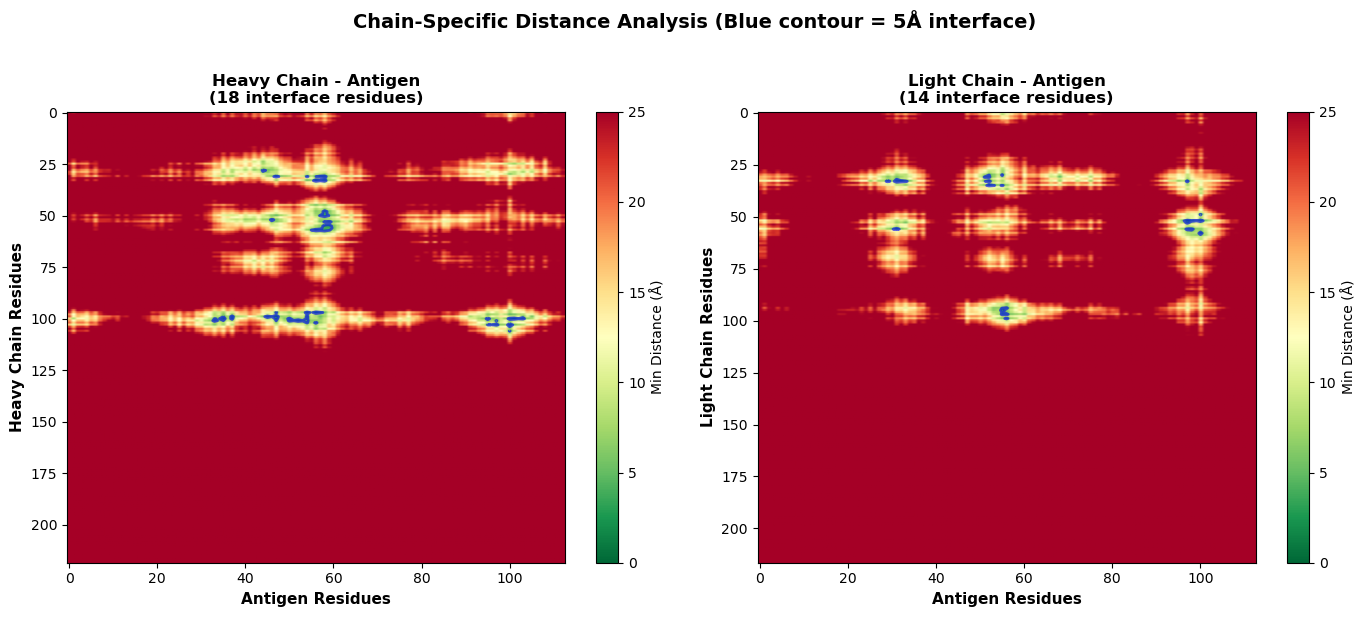


Interface Contributions:
  Heavy chain: 56.2%
  Light chain: 43.8%


In [32]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Convert to numpy if needed
if not hasattr(D_H, 'shape'):
    D_H_np = np.array(D_H)
    D_L_np = np.array(D_L)
else:
    D_H_np = D_H
    D_L_np = D_L

# Plot 1: Heavy chain distances
im1 = axes[0].imshow(D_H_np, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=25)
axes[0].contour(D_H_np, levels=[5.0], colors='blue', linewidths=2, alpha=0.6)
axes[0].set_xlabel('Antigen Residues', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Heavy Chain Residues', fontweight='bold', fontsize=11)
axes[0].set_title(f'Heavy Chain - Antigen\n({len(H_interface)} interface residues)', 
                 fontweight='bold', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Min Distance (Å)')

# Plot 2: Light chain distances
im2 = axes[1].imshow(D_L_np, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=25)
axes[1].contour(D_L_np, levels=[5.0], colors='blue', linewidths=2, alpha=0.6)
axes[1].set_xlabel('Antigen Residues', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Light Chain Residues', fontweight='bold', fontsize=11)
axes[1].set_title(f'Light Chain - Antigen\n({len(L_interface)} interface residues)', 
                 fontweight='bold', fontsize=12)
plt.colorbar(im2, ax=axes[1], label='Min Distance (Å)')

plt.suptitle('Chain-Specific Distance Analysis (Blue contour = 5Å interface)', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Calculate contribution percentages
total_interface = len(H_interface) + len(L_interface)
h_percent = 100 * len(H_interface) / total_interface
l_percent = 100 * len(L_interface) / total_interface

print(f"\nInterface Contributions:")
print(f"  Heavy chain: {h_percent:.1f}%")
print(f"  Light chain: {l_percent:.1f}%")

## 11. Key Findings Summary

In [33]:
print("=" * 80)
print("KEY FINDINGS: DISTANCE ANALYSIS SUMMARY".center(80))
print("=" * 80)

print("\n📏 Distance Matrix Dimensions:")
print(f"   • Atom-wise matrix:    {len(ab_atoms)} × {len(ag_atoms)} = {len(ab_atoms) * len(ag_atoms):,} distances")
print(f"   • Residue-wise matrix: {len(ab_residues)} × {len(ag_residues)} = {len(ab_residues) * len(ag_residues):,} distances")
print(f"   • All-vs-all matrix:   {len(all_labels)} × {len(all_labels)} = {len(all_labels) ** 2:,} distances")

print("\n🔍 Interface Statistics (< 5Å):")
print(f"   • Total residue-residue contacts: {len(interface_pairs)}")
print(f"   • Antibody interface residues:    {len(ab_interface)}")
print(f"   • Antigen interface residues:     {len(ag_interface)}")
print(f"   • Heavy chain contribution:       {len(H_interface)} residues ({h_percent:.1f}%)")
print(f"   • Light chain contribution:       {len(L_interface)} residues ({l_percent:.1f}%)")

print("\n📊 Distance Statistics:")
print(f"   • Closest atom-atom contact:      {contacts[0][0]:.2f} Å")
print(f"   • Closest residue-residue:        {min(min_distances):.2f} Å")
print(f"   • Mean minimum distance:          {np.mean(min_distances):.2f} Å")
print(f"   • Mean CA-CA distance:            {np.mean(ca_distances):.2f} Å")

print("\n🎯 Top Interface Residues:")
top_ab = ab_contact_counts.head(3)
top_ag = ag_contact_counts.head(3)
print(f"   • Top antibody: {', '.join([f'{res} ({count} contacts)' for res, count in top_ab.items()])}")
print(f"   • Top antigen:  {', '.join([f'{res} ({count} contacts)' for res, count in top_ag.items()])}")

print("\n" + "=" * 80)

                    KEY FINDINGS: DISTANCE ANALYSIS SUMMARY                     

📏 Distance Matrix Dimensions:
   • Atom-wise matrix:    3326 × 890 = 2,960,140 distances
   • Residue-wise matrix: 436 × 113 = 49,268 distances
   • All-vs-all matrix:   549 × 549 = 301,401 distances

🔍 Interface Statistics (< 5Å):
   • Total residue-residue contacts: 88
   • Antibody interface residues:    32
   • Antigen interface residues:     27
   • Heavy chain contribution:       18 residues (56.2%)
   • Light chain contribution:       14 residues (43.8%)

📊 Distance Statistics:
   • Closest atom-atom contact:      2.40 Å
   • Closest residue-residue:        2.40 Å
   • Mean minimum distance:          46.46 Å
   • Mean CA-CA distance:            49.51 Å

🎯 Top Interface Residues:
   • Top antibody: ARG H:101 (11 contacts), PHE H:102 (8 contacts), TYR L:34 (6 contacts)
   • Top antigen:  PRO A:59 (9 contacts), ARG A:56 (7 contacts), SER A:57 (7 contacts)



## END